In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# importing class object that I created
import sys  
sys.path.insert(0, '../src/')
import utils

In [3]:
tools = utils.tools() # create object

In [4]:
epi_data_df = tools.readfile('../data/processed/epi_vector.h5')
epi_data_df = tools.df

## Helper functions

In [279]:
# Drop column with all zeros
def dropZeroColumns(sample_df):
    sample_df = sample_df.loc[:, (sample_df != 0).any(axis=0)]
    return sample_df

In [280]:
def deleterows(df,column,value):
    df.drop(df [df[column] == value].index,inplace=True)
#     df.drop(df [df[column] == value2].index,inplace=True)
    return df

In [281]:
# Create column in sample_df for allergy tags
def addallergytoDF(df):
    for i in allergy_df.tag:
        df[i] = [i in tags for tags in df.tags]
    return df

In [282]:
# drop not relevent columns and drop rest of allergy column except one you are analyzing
def dropAllergyColumn(sample_df,allergy_col):
    sample_df = sample_df.drop(columns=['avg_rating','best_rating','prepare_again_rating','num_reviews'],axis=0)

    sample_df = sample_df.drop(columns=allergy_col,axis=0)

    return sample_df

In [283]:
# Seperate data and label to classify, 
# X are attribute columns used to classify, Y is the label
# first delete all infinity values in data
def getTrianData(sample_df,data_column,label_column):
    sample_df = sample_df[(sample_df != np.inf).all(axis=1)]
    data = sample_df.drop(columns=data_column, axis=1)
    label = sample_df[label_column]
    return data,label
# print(label.head(1))
# #X = X.astype('int32') # convert to int if needed
# data.head(25)

In [284]:
class SVCmodel(object):
    def __init__(self):
        pass
    def getSupport(self,model):
        '''Indices of support vectors'''
        return model.support_
    def getClassWeight(self,model):
        '''Support vectors'''
        return model.class_weight_
    def getNsupport(self,model):
        '''# of support vector for each class'''
        return model.n_support_
    def getsupportcoef(self,model):
        '''related to support vector in the decision function.'''
        return model.dual_coef_
    def getfeaturesweight(self,model):
        '''weight assigned to the features'''
        return model.coef_
    def getintercept(self,model):
        '''constants in decision function'''
        return model.intercept_
    def getfitstatus(self,model):
        '''0 if correctly fitted, 1 otherwise(will raise warning)'''
        return model.fit_status_
    def getclasses(self,model):
        '''The class label'''
        return model.classes_
    def getprobA(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2]'''
        return model.probA_
    def getprobB(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2].
        If probability=True, it corresponds to the parameters 
        learned in Platt scaling to produce probability estimates 
        from decision values. If probability=False, it’s an empty array. 
        Platt scaling uses the logistic function 
        1 / (1 + exp(decision_value * probA_ + probB_)) 
        where probA_ and probB_ are learned from the dataset 
        '''
        return model.probA_
    def getclassweight(self,model):
        '''multipliers of parameter C for each class.'''
        return model.class_weight_
    def getshapefit(self,model):
        return model.shape_fit_

## Data Preparation for Classification

In [5]:
sample_df = epi_data_df.head(10000)
# sample_df
# list(sample_df.columns.values)

In [7]:
sample_df.head(3)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis,avg_rating,best_rating,prepare_again_rating,num_reviews,tags,title
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,4.0,0.85,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese"
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.5,4.0,0.67,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day"""
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,4.0,0.75,4.0,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant"


In [8]:
# uncomment below lines to replace column with number greater than 0 to 1 to make it binary.
# columns = ['avg_rating','best_rating','worst_rating','prepare_again_rating','num_reviews','total_time', 'tags', 'title']
# df = sample_df.copy()
# for col in sample_df.columns:
#     if col not in columns:
#         df.loc[df[col] > 0, col] = 1
# df.head(25)

In [9]:
# Get count of tags
from collections import Counter
c = Counter()  
sample_df["tags"].apply(lambda x: c.update(x))
pass
# print(c)

In [10]:
# store tag count in df
count = pd.DataFrame()
count['tags_count'] = [c[i] for i in c]
count['tag'] = [i for i in c]
count = count.sort_values(by='tags_count',ascending=False)

# delete row with value < n
indexNames = count[ count['tags_count'] <= 30 ].index
 
# Delete these row indexes from dataFrame
count.drop(indexNames , inplace=True)
count

,tags_count,tag
19,4981,Peanut Free
20,4873,Soy Free
17,4372,Bon Appétit
3,4075,Vegetarian
34,4072,Tree Nut Free
...,...,...
123,31,Veal
212,31,Cookie
539,31,Beef Rib
354,31,New York


In [11]:
# look for ### Free tags
count['allergy_tags'] = count['tag'].str.endswith('Free')

allergy_df = count[count['allergy_tags'] == True]
allergy_df

,tags_count,tag,allergy_tags
19,4981,Peanut Free,True
20,4873,Soy Free,True
34,4072,Tree Nut Free,True
57,2712,Wheat/Gluten-Free,True
33,1590,Dairy Free,True
288,208,Fat Free,True


In [13]:
sample_df.head(1)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,prepare_again_rating,num_reviews,tags,title,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.85,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",False,False,False,False,False,False


In [16]:
# len(sample_df[["Breakfast" in x for x in sample_df.tags]])

In [17]:
# Uncomment below if need to encode data into unique value 


# from sklearn import preprocessing
# # label encoder
# le = preprocessing.LabelEncoder()

# # Converting string labels into numbers
# label = le.fit_transform(Y) # 0 ==> False, 1 ==> True
# label

# Uncomment below if need to convert X data into encoder and turn it into tuple list
#data.apply(le.fit_transform)
#data = [tuple(r) for r in data.values.tolist()]

In [18]:
# uncomment below if need to look for inf value in data 
# for col in X.columns:
#     print(X.loc[X[col] > 100000, col])

In [19]:
data1 = data[(data != np.inf).all(axis=1)]

In [20]:
data1.head()

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,ziti pasta,zucchini,"zucchini (about 5 medium), slice thin",zucchini blossom,"zucchini blossom, tear into large piece (optional)",zucchini flower,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculate Weight

* sample_weight is to be applied to individual samples (rows in your data). So the length of sample_weight must match the number of samples in your X.

* class_weight is to make the classifier give more importance and attention to the classes. So the length of class_weight must match the number of classes in your targets.

In [21]:
# Not need to do below to calculate weights. 

# from sklearn.utils import class_weight

# data_idx = data.idxmax(axis=1)

# class_weights = class_weight.compute_sample_weight('balanced',
#                                                   np.unique(data.values),
#                                                   label.values)

# y_ints = [y.argmax() for y in data_idx]
# type(y_ints)
# class_weight_dict = dict(enumerate(class_weight))

### Example from Sklearn Website

https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html

Automatically created module for IPython interactive environment


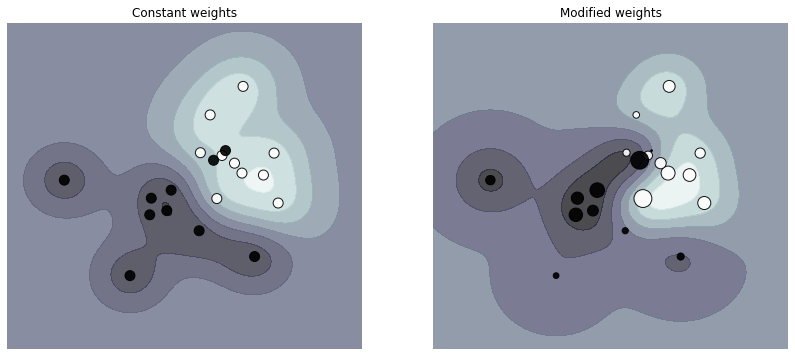

In [22]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm


def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without sample weights

# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, sample_weight_constant, axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1],
                       "Modified weights")

plt.show()

## Support Vector Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Below website gives good explaination on reading result from SVC

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

#### Fit model without weights

In [66]:
from sklearn import svm
C = 1
svc = svm.SVC(gamma=0.1,kernel='linear', C=C).fit(data.iloc[:1000], label[:1000]) 

In [67]:
result = model()
result.getClassWeight(svc)

array([1., 1.])

In [68]:
predict = []
predict.append(svc.predict(data.iloc[0:2]))

In [69]:
svc

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
classes = result.getclasses(svc)
classes

array([False,  True])

In [99]:
class_weight = result.getClassWeight(svc)
class_weight

array([1., 1.])

In [101]:
feature_weight = result.getfeaturesweight(svc)
# feature_weight = [x for x in feature_weight if x > 0.0]
# np.where(feature_weight > 0)
feature_weight.shape

(1, 7299)

In [29]:
x = data.iloc[:,:10].values

In [30]:
y = data.iloc[:,:10].values

In [32]:
x.size

99860

In [33]:
y.size

99860

In [43]:
# a = -class_weight[0] / class_weight[1]

# xx = np.linspace(0,50)
# yy = a * xx - feature_weight[0].max() / class_weight[1]
# print(xx.min(),yy.max())
# h0 = plt.plot(xx, yy, 'k-', label="non weighted div")

# plt.scatter(x, y,c=y)
# plt.ylim(yy.min(),50)
# plt.xlim(xx.min(),50)
# plt.legend()
# plt.show()

In [45]:

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import svm, datasets

# # import some data to play with
# iris = datasets.load_iris()
# X = data.iloc[:1000, :100]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = label.iloc[:1000]

# h = .02  # step size in the mesh

# # we create an instance of SVM and fit out data. We do not scale our
# # data since we want to plot the support vectors
# C = 1.0  # SVM regularization parameter
# svc = svm.SVC(kernel='linear', C=C).fit(X, y)
# rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
# poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
# lin_svc = svm.LinearSVC(C=C).fit(X, y)

# # create a mesh to plot in
# x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
# y_min, y_max = X.iloc[:, 100].min() - 1, X.iloc[:, 100].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# # title for the plots
# titles = ['SVC with linear kernel',
#           'LinearSVC (linear kernel)',
#           'SVC with RBF kernel',
#           'SVC with polynomial (degree 3) kernel']


# for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, x_max]x[y_min, y_max].
#     plt.subplot(2, 2, i + 1)
#     plt.subplots_adjust(wspace=0.4, hspace=0.4)

#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

#     # Plot also the training points
#     plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
#     plt.xlabel('Sepal length')
#     plt.ylabel('Sepal width')
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())
#     plt.xticks(())
#     plt.yticks(())
#     plt.title(titles[i])

# plt.show()

In [ ]:
# plot_decision_function(clf,clf.class_weight_,axes[0],'SVC without weights')

#### Fit model with weights

In [47]:
w_svc = svm.SVC(gamma=0.1,class_weight='balanced',probability=True).fit(data.iloc[:1000], label[:1000]) 

In [49]:
w_svc.predict(data.iloc[0:2])

array([False,  True])

In [50]:
w_svc.classes_

array([False,  True])

In [51]:
weights = w_svc.class_weight_
weights

array([1.01832994, 0.98231827])

## Naive Bayes Classifier

In [143]:
from sklearn.naive_bayes import GaussianNB

# # create a guassian classifier
bayes_model = GaussianNB()
bayes_model.fit(data,label)
print(bayes_model.epsilon_)

7.838258389368502e-06


In [144]:
bayes_model.predict(data.iloc[0:2])

array([False,  True])

## Other Stuff

In [115]:
# I manually took out tags that are not recipe ingredients. And clean input. 
# Uncomment below if  cuisine type is needed

cuisinetype = pd.read_csv('cuisinetype.txt',header=None)
cuisinetype = cuisinetype.transpose()
cuisinetype = np.array(cuisinetype[0])
cuisinetype = [x.replace('\'','') for x in cuisinetype]
cuisinetype = [x.replace('[','') for x in cuisinetype]
cuisinetype = [x.replace(']','') for x in cuisinetype]
cuisinetype = [x.lstrip() for x in cuisinetype]
# cuisinetype

In [116]:
# Uncomment below if states are needed

states = pd.read_csv('states.csv',header=None)
states = states.transpose()
states = np.array(states[0])
states = [x.lstrip() for x in states]
# states

In [117]:
# I manually took out cities of USA in the tag list.
# Uncomment below if usa_cuisine is needed

city = pd.read_csv('usa_city.csv',header=None)
city = city.transpose()
city = np.array(city[0])
city = [x.replace('\'','') for x in city]
city = [x.replace('[','') for x in city]
city = [x.replace(']','') for x in city]
city = [x.lstrip() for x in city]
usa_cuisine =states+city
# usa_cuisine

In [118]:
# create non_usa_cuisine list

non_usa_cuisine = []
for i in cuisinetype:
    if i not in usa_cuisine:
        non_usa_cuisine.append(i)


In [148]:
# non_usa_cuisine

In [123]:
tags_value=[]
for tags in corr_df['tags']:
    if(set(tags).intersection(usa_cuisine)):
        tags_value.append('True')
        continue
    else:
        if(set(tags).intersection(non_usa_cuisine)):
            tags_value.append('False')
        else:
            tags_value.append('NA')

In [285]:
def setupDataForCorr(corr_df,sample_size,data_column,label_column):
    corr_df = epi_data_df.head(sample_size)
    corr_df['usa_cuisine'] = tags_value
    # add allergy tags to df
    corr_df = addallergytoDF(corr_df)
    print("added allergy to DF", corr_df.shape)
    
    corr_df = dropZeroColumns(corr_df)
    print("Droped zero column",corr_df.shape)
    
    # delete rows with usa_cuisine ==> NA
    corr_df = deleterows(corr_df,'usa_cuisine','NA')
    corr_data,corr_label = getTrianData(corr_df,data_column,label_column)
    return corr_data,corr_label

In [286]:
drop_column = ['avg_rating','best_rating','prepare_again_rating','num_reviews','Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free','usa_cuisine','tags','title']
label_column = ['usa_cuisine']
corr_data,corr_label = setupDataForCorr(corr_df,10000,drop_column,label_column)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


added allergy to DF (10000, 17979)
Droped zero column (10000, 7312)


In [287]:
corr_data.head()

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,ziti pasta,zucchini,"zucchini (about 5 medium), slice thin",zucchini blossom,"zucchini blossom, tear into large piece (optional)",zucchini flower,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-drunken-pork-chops-427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-em-polow-em-persian-rice-with-pistachios-and-dill-352469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/-opulent-chicken-15810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/a-nineties-twist-to-a-grandmothers-roast-chicken-102023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
corr_df = epi_data_df.head(10000)

In [259]:
corr_df['usa_cuisine'] = tags_value
corr_df.head(1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,""" 00 "" (soft wheat) flour * or cake flour",""" 00 "" flour",""" 00 "" flour, divide",""" > chicken stock chicken broth",""" > panko (japanese bread crumb bread crumb",""" baby "" Pattypan squash",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" circular wire rack",...,ﬁne salt,avg_rating,best_rating,worst_rating,prepare_again_rating,num_reviews,total_time,tags,title,usa_cuisine
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,4.0,0.0,0.85,25.0,0.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",True


In [260]:
# add allergy tags to df
corr_df = addallergytoDF(corr_df)
corr_df.head(1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,""" 00 "" (soft wheat) flour * or cake flour",""" 00 "" flour",""" 00 "" flour, divide",""" > chicken stock chicken broth",""" > panko (japanese bread crumb bread crumb",""" baby "" Pattypan squash",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" circular wire rack",...,total_time,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",True,False,False,False,False,False,False


In [261]:
corr_df = dropZeroColumns(corr_df)
corr_df.head(5)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,num_reviews,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",True,False,False,False,False,False,False
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",NA,True,True,False,False,False,False
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant",NA,False,False,False,False,False,False
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor...",NA,True,True,True,False,True,False
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini",NA,True,True,True,False,False,False


In [262]:
corr_df.shape

(10000, 7312)

In [272]:
corr_df.drop(corr_df[corr_df['usa_cuisine'] == 'False'].index,inplace=True)
corr_df.drop(corr_df[corr_df['usa_cuisine'] == 'True'].index,inplace=True)
corr_df.shape
# corr_df.drop(corr_df.loc[corr_df['usa_cuisine'] == 'False'].index,inplace=True)

(9537, 7312)

In [225]:
corr_df.shape

(9537, 7312)

In [252]:
# corr_df = deleterows(corr_df,'usa_cuisine','True','False')

In [274]:

# data_column = ['usa_cuisine','tags','title']
# label_column = ['usa_cuisine']
corr_data,corr_label = getTrianData(corr_df,data_column,label_column)

In [277]:
corr_data.shape

(9523, 7309)

In [276]:
corr_label.shape

(9523, 1)

In [288]:
bayes_model.fit(corr_data,corr_label)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [289]:
bayes_model.predict(corr_data.iloc[0:2])

array(['True', 'True'], dtype='<U5')

In [216]:
print("Neither USA Cuisine or non-USA Cuisine: ",len(corr_df.loc[corr_df['usa_cuisine'] == 'NA']))
print("USA Cuisine: ",len(corr_df.loc[corr_df['usa_cuisine'] == 'True']))
print("Non-USA Cuisine: ",len(corr_df.loc[corr_df['usa_cuisine'] == 'False']))

Neither USA Cuisine or non-USA Cuisine:  9537
USA Cuisine:  353
Non-USA Cuisine:  110


In [ ]:
import plotly.express as px
import cufflinks as cf
from  plotly.offline import plot


In [ ]:
from sklearn.datasets.samples_generator import make_blobs 

x,y = make_blobs(n_samples=100,centers=3,n_features=3)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='spring'); 
plt.show()  

from this link: https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/

In [ ]:
from sklearn.naive_bayes import GaussianNB

# create a guassian classifier
model = GaussianNB()
# print(len(X_train))
# print(len(y_train))
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(y_pred)
# print(model.epsilon_)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=109)

In [ ]:
x = list(zip(X.Weather_Condition,X.Driver_Condition,X.Traffic_Violation))
# x
y = Y.Crash_Severity + Y.Seat_Belt
# print(y)
# y = list(zip(Y.Crash_Severity,Y.Seat_Belt))
# x
print(x[:5])
print("\n\n",y[:5])